# MACHINE VISION AND DATA ANALYSIS

## Micro Gesture project

### Contributors:

BRIGHT NUAKOH WIREDU

OLIVIER KANAMUGYIRE

### Importing Neccessary Modules

In [29]:
from utils.config import CFG
from utils.utils import save_ckp, load_ckp
from utils.dataset import MGDataset, MGDataloader, label_encodings
from transformers import BertTokenizer, DistilBertModel, DistilBertConfig, DistilBertTokenizer
from utils.models import RestMGModel
import itertools
import torch
import os
import torch.multiprocessing as mp
from utils.train import KLLoss, train_epoch, valid_epoch
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix

# Set start method to 'spawn'
mp.set_start_method('spawn', force=True)
writer = SummaryWriter()

In [2]:
torch.backends.cudnn.benchmark = True

### Lading Data For Training

In [3]:
tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
dataset = MGDataset(root_dir=CFG.image_path,labels_enc=label_encodings,tokenizer=tokenizer)

In [4]:
# Split the dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

# Create data loaders for each split
train_loader = MGDataloader(train_dataset)
val_loader = MGDataloader(val_dataset)
test_loader = MGDataloader(test_dataset, data_set ="test")

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 42359
Validation size: 12102
Test size: 6053


### Creating Model

In [5]:
# Initialize model, optimizer, and LR scheduler


model = RestMGModel().to(CFG.device)
params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]

optimizer = torch.optim.AdamW(params, weight_decay=0.)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
step = "epochs"

# # 3. Load states
model.load_state_dict(torch.load("./utils/modelscheckpoints/best_0.93.pth"))

<All keys matched successfully>

Defining Loss

In [6]:
# Define Loss function
loss_fn = KLLoss()

# Initialize best_loss and best accuracy
best_loss = float('inf')
best_acc = 0

In [ ]:
# model.load_state_dict(torch.load("./utils/modelscheckpoints/best_0.79.pth"))
# #step = "epochs"
# #checkpoint = torch.load("utils/modelscheckpoints/ckpt_epoch_29.pth", map_location='cuda')

# # . Load states
# #optimizer.load_state_dict(checkpoint['optimizer'])
# #lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])

In [7]:
train_l =[]
val_l = []
train_acc = []
for epoch in range(CFG.epochs):
    print(f"Epoch: {epoch + 1}")
    # Training phase
    model.train()
    train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step, loss_fn)
    if (epoch+1)%5 == 0:
        state = {'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'lr_scheduler': lr_scheduler.state_dict(),
                        'epoch': epoch}
        save_ckp(state, epoch, CFG.checkpoint_dir)
    writer.add_scalar('train_loss', train_loss.avg, epoch)
    train_l.append(train_loss.avg)
    # Validation phase
    model.eval()
    with torch.no_grad():
        valid_loss,acc,acc_5 = valid_epoch(model, val_loader, loss_fn)
        writer.add_scalar('valid_loss', valid_loss.avg, epoch)
        writer.add_scalar('acc@1', acc, epoch)
        writer.add_scalar('acc@1', acc_5, epoch)
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), os.path.join(CFG.checkpoint_dir, f'best_{round(best_acc, 2)}.pth'))
        print("Saved Best Model!")
    if valid_loss.avg < best_loss:
        best_loss = valid_loss.avg
        print("Best Loss")
    lr_scheduler.step(valid_loss.avg)
    train_acc.append((acc,acc_5))
    val_l.append(valid_loss.avg )

Epoch: 1


  0%|          | 0/662 [00:00<?, ?it/s]

/home/students/bnuakoh/miniconda3/lib/python3.12/site-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


  0%|          | 0/190 [00:00<?, ?it/s]

Val_Acc@1 == 88.42%
Val_Acc@5 == 98.54%
Saved Best Model!
Best Loss
Epoch: 2


  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

Val_Acc@1 == 87.89%
Val_Acc@5 == 97.94%
Epoch: 3


  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

Val_Acc@1 == 88.01%
Val_Acc@5 == 97.80%
Epoch: 4


  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

Val_Acc@1 == 89.00%
Val_Acc@5 == 97.71%
Saved Best Model!
Epoch: 5


  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

Val_Acc@1 == 87.78%
Val_Acc@5 == 97.38%


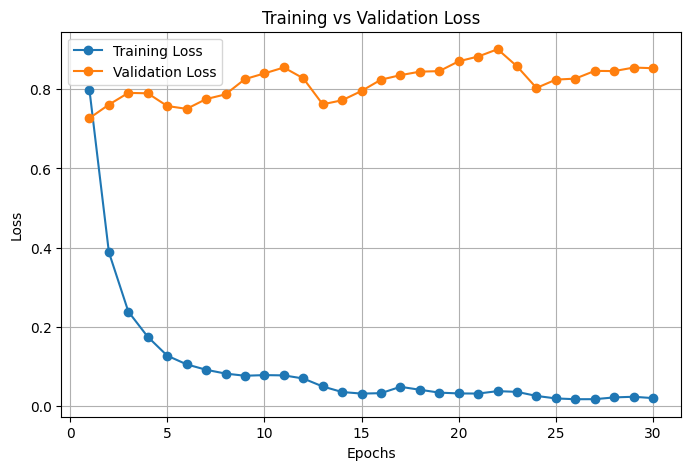

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_l)+1), train_l, label='Training Loss', marker='o')
plt.plot(range(1, len(train_l)+1), val_l, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

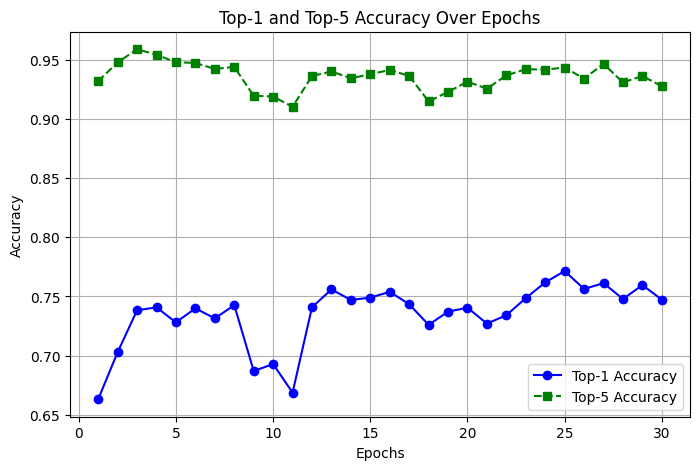

In [18]:
top1_acc = [x[0] for x in train_acc]
top5_acc = [x[1] for x in train_acc]
plt.figure(figsize=(8, 5))

# Plot Top-1 Accuracy
ep = list(range(1, len(top5_acc) + 1))
plt.plot(ep, top1_acc, label="Top-1 Accuracy", marker='o', linestyle='-', color='b')

# Plot Top-5 Accuracy
plt.plot(ep, top5_acc, label="Top-5 Accuracy", marker='s', linestyle='--', color='g')

# Labels and Title
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Top-1 and Top-5 Accuracy Over Epochs")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

Test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6399999].


Image batch shape: torch.Size([1, 3, 224, 224])
Label batch shape: 1


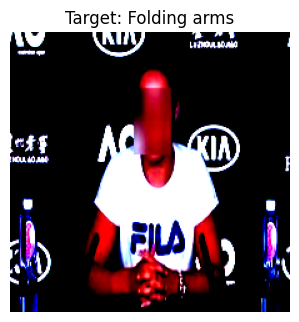

In [ ]:


# Get one batch from the dataloader
batch = next(iter(test_loader))

# Assuming batch is a dictionary or a tuple:
# Typical structure: {'image': tensor, 'input_ids': tensor, 'attention_mask': tensor, 'label': tensor}
images = batch['image']        # shape: (batch_size, 3, H, W)
labels = batch['caption']        # or 'target' depending on how you named it
input_ids = batch.get('input_ids', None)  # if text is included

print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {len(labels)}")

# Visualizing the first 4 samples:
images_np = images.permute(0, 2, 3, 1).cpu().numpy()  # back to (B, H, W, C)

plt.figure(figsize=(12, 8))
for i in range(min(4, len(images_np))):
    plt.subplot(2, 2, i+1)
    plt.imshow(images_np[i])
    plt.title(f"Target: {labels[i]}")
    plt.axis('off')
plt.show()



### Testing Model On Test Set

In [6]:
from tqdm.notebook import tqdm

In [ ]:
# Initialize tqdm progress bar
tqdm_object = tqdm(test_loader, total=len(test_loader))

#model.eval()
# # 3. Load Best
model.load_state_dict(torch.load("./utils/modelscheckpoints/best_0.93.pth"))

# Initialize tokenizer and encode captions
tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
encoded_captions = tokenizer(list(label_encodings.values()), padding=True, truncation=True, max_length=CFG.max_length)
item = {key: torch.tensor(values) for key, values in encoded_captions.items()}

total = len(tqdm_object)
model.eval()
acc_t1 ,acc_t5 = 0.0, 0.0
with torch.no_grad():
    for batch in tqdm_object:
            # Use model to encode image and text features
        image_features = model.image_encoder(batch["image"].to(CFG.device))
        #image_features = image_features.repeat(len(labels),1,1,1,1)
        text_features = model.text_encoder(input_ids=item["input_ids"].to(CFG.device), attention_mask=item["attention_mask"].to(CFG.device))

            # Get embeddings from model projections
        image_embeddings = model.image_projection(image_features)
        text_embeddings = model.text_projection(text_features)

            # Calculate the dot product similarity between image and text embeddings
        dot_similarity = image_embeddings @ text_embeddings.T

        values, indices_pred = torch.topk(dot_similarity.squeeze(0), 5)
        indices_pred = indices_pred.detach().cpu().numpy()

        target = batch["caption"]
        
        pred_5 = [label_encodings[indices_pred[idx] + 1] for idx in range(5)]
        if pred_5[0] == target[0]:
            acc_t1 +=1
            acc_t5 += 1
        elif  target[0] in pred_5:
            acc_t5 += 1
        predictions.append(indices_pred)

    acc_1 = acc_t1/total
    acc_5 = acc_t5/total
print("Test accuracy at top 1 :{:.2f}%".format(acc_1))
print("Test accuracy at top 5 :{:.2f}%".format(acc_5))

  0%|          | 0/6053 [00:00<?, ?it/s]

Test accuracy at top 1 :0.97%
Test accuracy at top 5 :1.00%


### Data With No Labels

In [12]:
predictions = []

model.eval()
 
with torch.no_grad():
    for batch in tqdm_object:
        # Use model to encode image and text features
        image_features = model.image_encoder(batch["image"].to(CFG.device))
        text_features = model.text_encoder(input_ids=item["input_ids"].to(CFG.device), attention_mask=item["attention_mask"].to(CFG.device))

        # Get embeddings from model projections
        image_embeddings = model.image_projection(image_features)
        text_embeddings = model.text_projection(text_features)

        # Calculate the dot product similarity between image and text embeddings
        dot_similarity = image_embeddings @ text_embeddings.T

        # Get the top-5 values and corresponding indices
        values, indices_pred = torch.topk(dot_similarity.squeeze(0), 1)
        indices_pred = indices_pred.detach().cpu().numpy()

            
        predicted_id = indices_pred + 1
            
        predictions.append(predicted_id)

In [26]:
test_id = [key for batch in test_loader for key, value in label_encodings.items() if batch["caption"][0] == value]


In [17]:
predictions

[array([8]),
 array([16]),
 array([25]),
 array([26]),
 array([15]),
 array([31]),
 array([22]),
 array([4]),
 array([26]),
 array([9]),
 array([16]),
 array([13]),
 array([26]),
 array([26]),
 array([26]),
 array([17]),
 array([25]),
 array([26]),
 array([26]),
 array([26]),
 array([9]),
 array([26]),
 array([26]),
 array([25]),
 array([16]),
 array([25]),
 array([17]),
 array([26]),
 array([19]),
 array([19]),
 array([26]),
 array([16]),
 array([16]),
 array([25]),
 array([8]),
 array([26]),
 array([3]),
 array([26]),
 array([19]),
 array([13]),
 array([26]),
 array([15]),
 array([4]),
 array([25]),
 array([17]),
 array([26]),
 array([13]),
 array([25]),
 array([25]),
 array([3]),
 array([20]),
 array([13]),
 array([26]),
 array([12]),
 array([17]),
 array([3]),
 array([26]),
 array([14]),
 array([26]),
 array([13]),
 array([27]),
 array([9]),
 array([17]),
 array([26]),
 array([16]),
 array([26]),
 array([4]),
 array([22]),
 array([25]),
 array([19]),
 array([30]),
 array([26]),
 ar

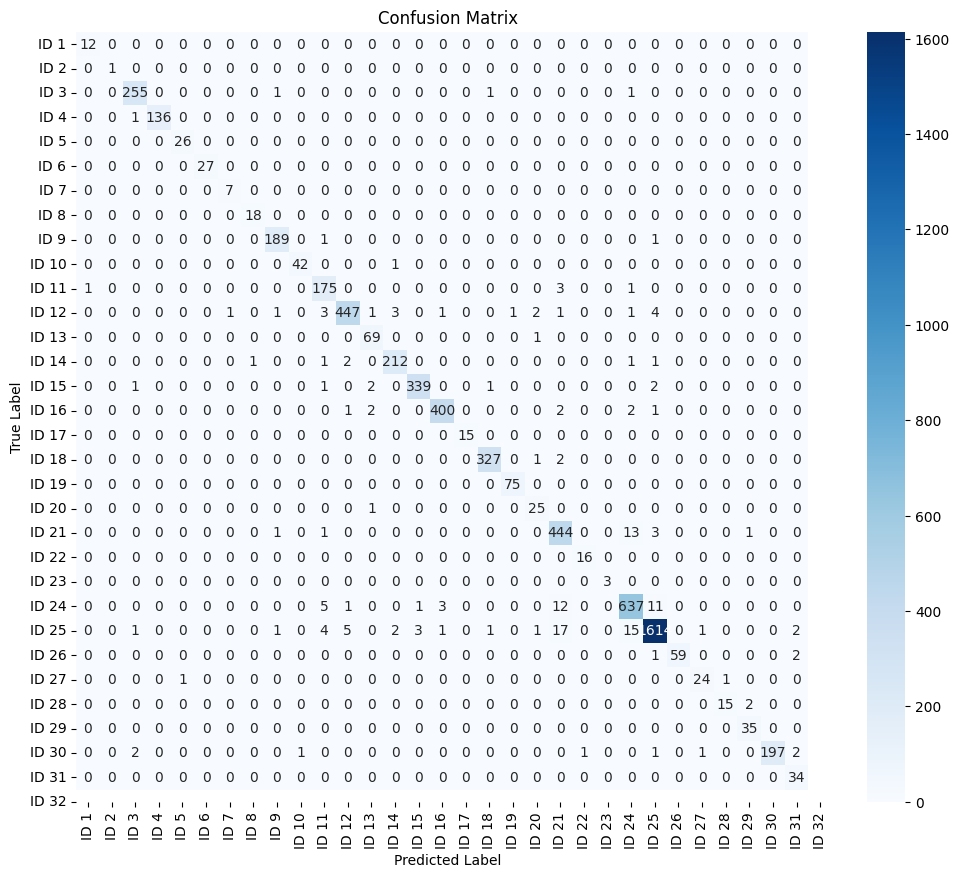

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming test_id and predictions are lists of true & predicted labels
cm = confusion_matrix(test_id, predictions)

# Define label names (adjust if necessary)
num_labels = 32
labels = [f"ID {i}" for i in range(1,num_labels+1)]  # Change this if you have custom labels

# Plot
plt.figure(figsize=(12, 10))  # Adjust figure size for clarity
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Formatting
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.yticks(rotation=0)

# Show plot
plt.show()


In [40]:
print(classification_report(test_id,predictions))

              precision    recall  f1-score   support

           1       0.92      1.00      0.96        12
           2       1.00      1.00      1.00         1
           3       0.98      0.99      0.98       258
           4       1.00      0.99      1.00       137
           5       0.96      1.00      0.98        26
           6       1.00      1.00      1.00        27
           7       0.88      1.00      0.93         7
           8       0.95      1.00      0.97        18
           9       0.98      0.99      0.98       191
          10       0.98      0.98      0.98        43
          12       0.92      0.97      0.94       180
          13       0.98      0.96      0.97       466
          14       0.92      0.99      0.95        70
          15       0.97      0.97      0.97       218
          16       0.99      0.98      0.98       346
          17       0.99      0.98      0.98       408
          18       1.00      1.00      1.00        15
          19       0.99    